In [ ]:

# --- Sanity ---
def test_distribute_sanity():
    print("✅ from distribute.ipynb")


all_files = ['107f24d6e9_F1BE1D4184INSPIRE', '11cdce7802_B6A62F8BE0INSPIRE', '12fa5e614f_53197F206FOPENPIPELINE', '130a76ebe1_68B40B480AOPENPIPELINE', '1476907971_CHADGRISMOPENPIPELINE', '1553541487_APIGENERATED', '1553541585_APIGENERATED', '1553627230_APIGENERATED', '15efe45820_D95DF0B1F4INSPIRE', '1726eb08ef_60693DB04DINSPIRE', '1d056881e8_29FEA32BC7INSPIRE', '1d4fbe33f3_F1BE1D4184INSPIRE', '1df70e7340_4413A67E91INSPIRE', '2552eb56dd_2AABB46C86OPENPIPELINE', '25f1c24f30_EB81FE6E2BOPENPIPELINE', '2ef3a4994a_0CCD105428INSPIRE', '2ef883f08d_F317F9C1DFOPENPIPELINE', '34fbf7c2bd_E8AD935CEDINSPIRE', '3502e187b2_23071E4605OPENPIPELINE', '39e77bedd0_729FB913CDOPENPIPELINE', '420d6b69b8_84B52814D2OPENPIPELINE', '520947aa07_8FCB044F58OPENPIPELINE', '551063e3c5_8FCB044F58INSPIRE', '57426ebe1e_84B52814D2OPENPIPELINE', '5fa39d6378_DB9FF730D9OPENPIPELINE', '6f93b9026b_F1BFB8B17DOPENPIPELINE', '7008b80b00_FF24A4975DINSPIRE', '74d7796531_EB81FE6E2BOPENPIPELINE', '7c719dfcc0_310490364FINSPIRE', '84410645db_8D20F02042OPENPIPELINE', '8710b98ea0_06E6522D6DINSPIRE', '888432f840_80E7FD39EBINSPIRE', '9170479165_625EDFBAB6OPENPIPELINE', 'a1af86939f_F1BE1D4184OPENPIPELINE', 'b61673f780_4413A67E91INSPIRE', 'b705d0cc9c_E5F5E0E316OPENPIPELINE', 'b771104de5_7E02A41EBEOPENPIPELINE', 'c2e8370ca3_3340CAC7AEOPENPIPELINE', 'c37dbfae2f_84B52814D2OPENPIPELINE', 'c644f91210_27E21B7F30OPENPIPELINE', 'c6d131e346_536DE05ED2OPENPIPELINE', 'c8a7031e5f_32156F5DC2INSPIRE', 'cc4b443c7d_A9CBEF2C97INSPIRE', 'd06b2c67d2_2A62B67B52OPENPIPELINE', 'd9161f7e18_C05BA1BC72OPENPIPELINE', 'dabec5e872_E8AD935CEDINSPIRE', 'e87da4ebdb_29FEA32BC7INSPIRE', 'ebffe540d0_7BA042D858OPENPIPELINE', 'ec09336a6f_06BA0AF311OPENPIPELINE', 'f0747ed88d_E74C0DD8FDOPENPIPELINE', 'f4dd768188_NOLANOPENPIPELINE', 'f56b6b2232_2A62B67B52OPENPIPELINE', 'f971256246_MIKEINSPIRE', 'f9f43e5144_1DB9E6F68BINSPIRE', 'fc5837dcf8_7CD52BE09EINSPIRE']


train_files = [

    "d9161f7e18_C05BA1BC72OPENPIPELINE",
    "c2e8370ca3_3340CAC7AEOPENPIPELINE",
    "1d4fbe33f3_F1BE1D4184INSPIRE",
    "551063e3c5_8FCB044F58INSPIRE",
    "ec09336a6f_06BA0AF311OPENPIPELINE",
    
    "2ef883f08d_F317F9C1DFOPENPIPELINE",
    "c37dbfae2f_84B52814D2OPENPIPELINE",
    "f4dd768188_NOLANOPENPIPELINE",
    "1553541585_APIGENERATED",
    "dabec5e872_E8AD935CEDINSPIRE",
    "b61673f780_4413A67E91INSPIRE",
    "d06b2c67d2_2A62B67B52OPENPIPELINE",
    "cc4b443c7d_A9CBEF2C97INSPIRE",
    "11cdce7802_B6A62F8BE0INSPIRE",
    "1476907971_CHADGRISMOPENPIPELINE",


    "c68d5dd5e5_8D20F0,2042OPENPIPELINE",
    "ae5f6f1a67_E8AD935CEDINSPIRE",
    "203b0f447b_536DE05ED2OPENPIPELINE",
    "c0b48f9e09_84B52814D2OPENPIPELINE",
    "89d1b23f42_60693DB04DINSPIRE",
    "aa7e37f4e2_625EDFBAB6OPENPIPELINE",
    "fc2f3b5504_8FCB044F58OPENPIPELINE",
    "b0d23b19d8_A9CBEF2C97INSPIRE",
    "6e13af485d_53197F206FOPENPIPELINE",
    "7c216a3883_0CCD105428INSPIRE"
]

val_files = [
    "1476907971_CHADGRISMOPENPIPELINE",
    "dabec5e872_E8AD935CEDINSPIRE",
    "c6d131e346_536DE05ED2OPENPIPELINE",
    "57426ebe1e_84B52814D2OPENPIPELINE",
    "1726eb08ef_60693DB04DINSPIRE",
    "9170479165_625EDFBAB6OPENPIPELINE",
    "520947aa07_8FCB044F58OPENPIPELINE",
    "cc4b443c7d_A9CBEF2C97INSPIRE",
    "12fa5e614f_53197F206FOPENPIPELINE",
    "2ef3a4994a_0CCD105428INSPIRE",
]

test_files = [
    "1d4fbe33f3_F1BE1D4184INSPIRE",
    "f9f43e5144_1DB9E6F68BINSPIRE",
    "25f1c24f30_EB81FE6E2BOPENPIPELINE",
    "a1af86939f_F1BE1D4184OPENPIPELINE",
    "1553541487_APIGENERATED",
    "74d7796531_EB81FE6E2BOPENPIPELINE",
    "8710b98ea0_06E6522D6DINSPIRE",
    "c644f91210_27E21B7F30OPENPIPELINE",
    "d9161f7e18_C05BA1BC72OPENPIPELINE", 
]

,Class,Target,Actual,Difference
0,Building,0.20,0.261089,0.061089
1,Clutter,0.05,0.014737,-0.035263
2,Vegetation,0.10,0.089185,-0.010815
3,Water,0.35,0.229258,-0.120742
4,Background,0.10,0.389213,0.289213
5,Car,0.20,0.016517,-0.183483


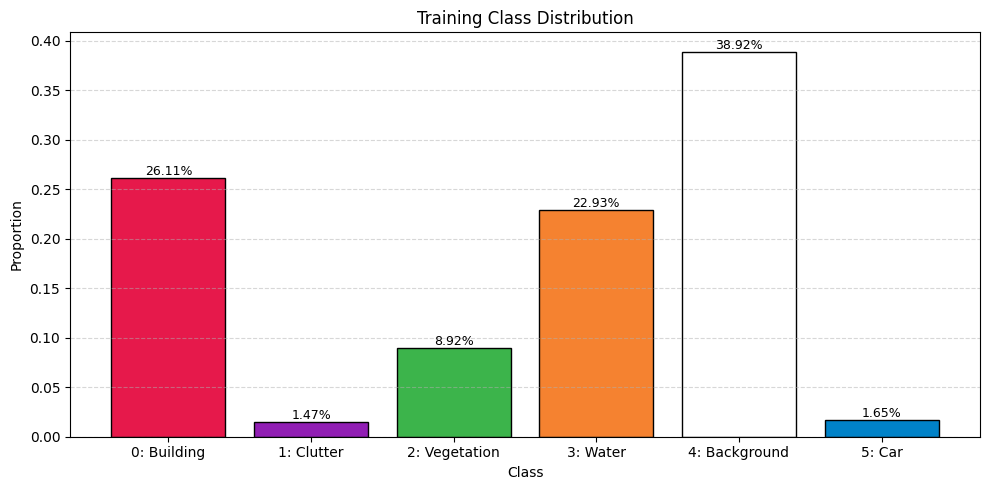


📦 Selected 3,739 chips from 29,915 total (12.50% of available training chips)


,tile_id,source_file,x,y,0: Building,1: Clutter,2: Vegetation,3: Water,4: Background,5: Car,entropy,total,0: Building_norm,1: Clutter_norm,2: Vegetation_norm,3: Water_norm,4: Background_norm,5: Car_norm,score
18370,107f24d6e9_F1BE1D4184INSPIRE_9088_5504,107f24d6e9_F1BE1D4184INSPIRE,9088,5504,0.188522,0.000000,0.102631,0.301987,0.406860,0.000000,1.840420,1.0,0.188522,0.000000,0.102631,0.301987,0.406860,0.000000,0.618982
18866,107f24d6e9_F1BE1D4184INSPIRE_8320_9344,107f24d6e9_F1BE1D4184INSPIRE,8320,9344,0.246445,0.000000,0.011612,0.400711,0.341232,0.000000,1.630622,1.0,0.246445,0.000000,0.011612,0.400711,0.341232,0.000000,0.676776
18025,107f24d6e9_F1BE1D4184INSPIRE_7936_3840,107f24d6e9_F1BE1D4184INSPIRE,7936,3840,0.382935,0.029480,0.159805,0.203232,0.224548,0.000000,2.054031,1.0,0.382935,0.029480,0.159805,0.203232,0.224548,0.000000,0.734576
18702,107f24d6e9_F1BE1D4184INSPIRE_9472_8192,107f24d6e9_F1BE1D4184INSPIRE,9472,8192,0.204987,0.000000,0.156326,0.231537,0.407150,0.000000,1.903742,1.0,0.204987,0.000000,0.156326,0.231537,0.407150,0.000000,0.736926
18096,107f24d6e9_F1BE1D4184INSPIRE_9600_4096,107f24d6e9_F1BE1D4184INSPIRE,9600,4096,0.102463,0.003647,0.103149,0.317215,0.473526,0.000000,1.740501,1.0,0.102463,0.003647,0.103149,0.317215,0.473526,0.000000,0.753351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27627,888432f840_80E7FD39EBINSPIRE_1920_3584,888432f840_80E7FD39EBINSPIRE,1920,3584,0.000000,0.000000,0.709534,0.119629,0.170837,0.000000,1.153243,1.0,0.000000,0.000000,0.709534,0.119629,0.170837,0.000000,1.360742
29413,15efe45820_D95DF0B1F4INSPIRE_5760_4992,15efe45820_D95DF0B1F4INSPIRE,5760,4992,0.754440,0.001465,0.018158,0.000000,0.225937,0.000000,0.910362,1.0,0.754440,0.001465,0.018158,0.000000,0.225937,0.000000,1.360754
12087,420d6b69b8_84B52814D2OPENPIPELINE_7168_7808,420d6b69b8_84B52814D2OPENPIPELINE,7168,7808,0.000000,0.000000,0.019592,0.000000,0.675659,0.304749,1.015766,1.0,0.000000,0.000000,0.019592,0.000000,0.675659,0.304749,1.360815
29520,15efe45820_D95DF0B1F4INSPIRE_7168_5888,15efe45820_D95DF0B1F4INSPIRE,7168,5888,0.880417,0.000000,0.076614,0.000000,0.042969,0.000000,0.640823,1.0,0.880417,0.000000,0.076614,0.000000,0.042969,0.000000,1.360834


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_path = "/content/chipped_data/content/chipped_data/train_metadata.csv"
raw_path = "/content/chipped_data/content/chipped_data/raw/raw_metadata.csv"

#train_path = "train_metadata.csv"
#raw_path = "raw_metadata.csv"


NUM_CLASSES = 6
class_cols = ['0: Building', '1: Clutter', '2: Vegetation', '3: Water', '4: Background', '5: Car']
CLASS_NAMES = ['Building', 'Clutter', 'Vegetation', 'Water', 'Background', 'Car']
COLOR_TO_CLASS = {
    (230, 25, 75): 0,
    (145, 30, 180): 1,
    (60, 180, 75): 2,
    (245, 130, 48): 3,
    (255, 255, 255): 4,
    (0, 130, 200): 5,
    (255, 0, 255): 6 # Ignore pixel for visualisation
}
CLASS_TO_COLOR = {v: k for k, v in COLOR_TO_CLASS.items() if v < 6} # Exclude ignore color

def csv_to_df(split, ignore_threshold=0.95):
    """
    Returns a DataFrame filtered by split with optional ignore pixel filtering for val/test.
    
    Args:
        split (str): One of 'train', 'val', or 'test'
        metadata_path (str): Path to metadata.csv
        ignore_threshold (float): Maximum allowed ignore pixel ratio for val/test

    Returns:
        pd.DataFrame: Filtered DataFrame for the requested split
    """
    if split == 'train':
        df = pd.read_csv(train_path)
        #return df[df['tile_id'].apply(lambda tid: any(tid.startswith(p) for p in train_files))].copy()
        # Drop rows whose tile_id starts with a val or test prefix
        excluded_prefixes = val_files + test_files
        is_excluded = df['tile_id'].apply(lambda tid: any(tid.startswith(prefix) for prefix in excluded_prefixes))
        train_df = df[~is_excluded].copy()

        # Updated class columns to match the correct format
        class_cols = ['0: Building', '1: Clutter', '2: Vegetation', '3: Water', '4: Background', '5: Car']

        # Updated targets
        targets = {
            '0: Building': 0.2,
            '1: Clutter': 0.05,
            '2: Vegetation': 0.1,
            '3: Water': 0.35,
            '4: Background': None,
            '5: Car': 0.2
        }
        targets['4: Background'] = 1 - sum(v for v in targets.values() if v is not None)

        # Recompute train_df without val/test tiles
        is_excluded = df['tile_id'].apply(lambda tid: any(tid.startswith(prefix) for prefix in excluded_prefixes))
        train_df = df[~is_excluded].copy()

        # Normalise all rows to get per-chip class proportions
        train_df['total'] = train_df[class_cols].sum(axis=1)
        for col in class_cols:
            train_df[col + '_norm'] = train_df[col] / train_df['total']

        # Score rows by how well they match the target proportions (L1 distance)
        def compute_score(row):
            return sum(abs(row[col + '_norm'] - tgt) for col, tgt in targets.items())

        train_df['score'] = train_df.apply(compute_score, axis=1)

        # Select subset
        target_fraction = 0.075
        tolerance = 0.05
        min_chips = int(len(train_df) * (target_fraction - tolerance))
        max_chips = int(len(train_df) * (target_fraction + tolerance))
        train_df_sorted = train_df.sort_values('score').head(max_chips)

        # Compute actual achieved distribution
        subset = train_df_sorted[class_cols].sum()
        actual_distribution = subset / subset.sum()

        # Build summary
        summary_df = pd.DataFrame({
            'Class': [col.split(":")[1].strip() for col in class_cols],
            'Target': [targets[col] for col in class_cols],
            'Actual': actual_distribution.values
        })
        summary_df['Difference'] = summary_df['Actual'] - summary_df['Target']

        from IPython.display import display
        display(summary_df)
        plot_class_distribution_from_df(train_df_sorted, title="Training Class Distribution")
        actual_chip_count = len(train_df_sorted)
        original_chip_count = len(train_df)
        actual_fraction = actual_chip_count / original_chip_count

        print(f"\n📦 Selected {actual_chip_count:,} chips from {original_chip_count:,} total "
              f"({actual_fraction:.2%} of available training chips)")

        return train_df_sorted


    elif split in ['val', 'test']:
        df = pd.read_csv(raw_path)
        file_list = val_files if split == 'val' else test_files

        # Filter by matching tile IDs
        df = df[df['tile_id'].apply(lambda tid: any(tid.startswith(p) for p in file_list))].copy()

        # Sum class columns 0: to 5: to estimate non-ignore content
        class_cols = [col for col in df.columns if any(col.startswith(f"{i}:") for i in range(6))]
        df['non_ignore_sum'] = df[class_cols].sum(axis=1)

        required_non_ignore = 1.0 - ignore_threshold
        df = df[df['non_ignore_sum'] >= required_non_ignore].copy()
        return df

    else:
        raise ValueError(f"Invalid split: {split}. Choose from 'train', 'val', 'test'.")




# --- Function ---
def plot_class_distribution_from_df(dataframe, title="Training Class Distribution"):
    pixel_sums = dataframe[class_cols].sum()
    pixel_props = pixel_sums / pixel_sums.sum()

    class_labels = [f"{i}: {CLASS_NAMES[i]}" for i in range(NUM_CLASSES)]
    colours = [np.array(CLASS_TO_COLOR[i]) / 255.0 for i in range(NUM_CLASSES)]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_labels, pixel_props, color=colours, edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    for bar, prop in zip(bars, pixel_props):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{prop:.2%}",
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


#csv_to_df('train', ignore_threshold=0.95)

